In [2]:
import torch
import torch.nn as nn
import numpy as np
import random
from matplotlib import pyplot as plt
%matplotlib inline

C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from micrograd.engine import Value
from micrograd.nn import MLP, Layer, Neuron

In [4]:
np.random.seed(1337)
random.seed(1337)

[[-0.00822168  1.02045668]
 [ 0.95747723 -0.48471923]
 [ 0.63875951  0.73689958]
 [ 2.12019256  0.3876265 ]
 [ 1.47099698 -0.60864877]
 [-0.44075488  0.91175852]
 [-0.84375716  0.70056419]
 [-0.32493232  0.97095215]
 [ 0.37598292 -0.47180207]
 [ 0.30802103 -0.09675001]
 [ 0.77545941 -0.49852587]
 [ 0.32035499  1.06662853]
 [-0.87507854  0.29779115]
 [-0.71150799  0.55020065]
 [ 1.11167311  0.13280597]
 [ 1.68903881 -0.33331714]
 [-0.06362     0.85368569]
 [ 0.64478223 -0.37769984]
 [ 0.16301301  0.82228854]
 [-0.45196205  0.82688175]
 [ 0.6748645  -0.32019136]
 [-0.93271789  0.0777    ]
 [ 0.82207264  0.63048868]
 [ 2.01068269  0.32310992]
 [ 1.0369107  -0.51763742]
 [ 1.92437928  0.27961777]
 [ 1.08098476  0.0618447 ]
 [-0.77785518  0.75975318]
 [ 0.04416255  0.86206061]
 [ 0.22260713  0.10059634]
 [ 0.11705531  0.81496964]
 [ 0.64751597  0.72951866]
 [ 0.37787852  0.91297233]
 [-0.59181094  0.84362764]
 [ 0.02176585  0.17336498]
 [-0.12824533  0.8000999 ]
 [ 0.43878127  0.90526244]
 

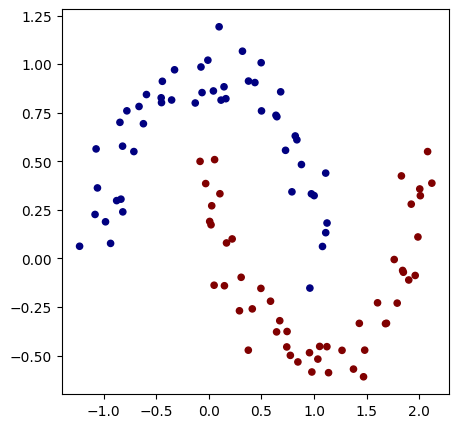

In [9]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)
y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
print(X)
print(y)
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [6]:
model = MLP(2, [16, 16, 1])  # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))


MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [7]:
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0)
                for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)


total_loss, acc = loss()
print(total_loss, acc)


Value(data=0.8958441028683222, grad=0) 0.5


In [ ]:
for k in range(100):

    total_loss, acc= loss()

    #backward pass
    model.zero_grad()

    total_loss.backward()

    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


(-1.548639298268643, 1.951360701731357)

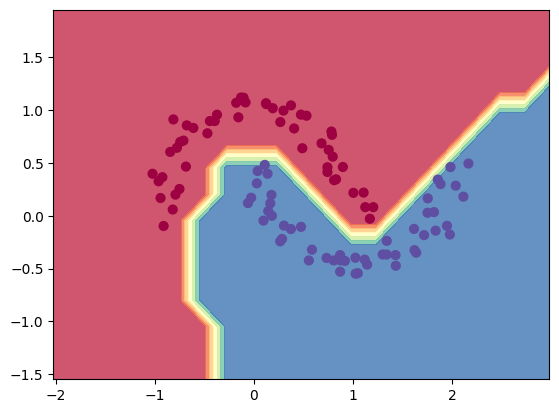

In [10]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
